In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/TACTILEDRIVEN_ARTO/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rl_sim/TACTILEDRIVEN_ARTO/ML_Levers_Knobs/DATA/1D_KNOB_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)
print("y_data.[0] max: ", np.max(y_data))

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

data_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test
}
def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = np.dstack((data[:,:,2], data[:,:,4]))
        globals()[f"{key}2"] = data[:,:,0]
        globals()[f"{key}3"] = data[:,:,5]
        globals()[f"{key}4"] = np.dstack((data[:,:,1], data[:,:,3]))

assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)
print("X_train4 shape:", X_train4.shape)

import tensorflow as tf

WS_B = 2000  # Example sequence length
input_shape1 = (WS_B, 2)
input_shape2 = (WS_B, 1)
input_shape3 = (WS_B, 1)
input_shape4 = (WS_B, 2)
OUT_N = int(np.max(y_data)) + 1  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N))  # Generate labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

def compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)")
    axs[0].plot(history.history["val_loss"], label="val_loss")
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy")
    axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels)
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


2024-09-11 00:34:27.661339: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 00:34:27.686398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 00:34:28.089416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_data shape: (629, 2000, 9)
y_data shape: (629,)
X_data.[0] shape:  (2000, 9)
y_data.[0] max:  5.0
TOTAL DATA: 629  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (377, 2000, 9)    ||  Dimensions of y_train: (377,)
Dimensions of X_test:  (126, 2000, 9)    ||  Dimensions of y_test:  (126,)
Dimensions of X_val:   (126, 2000, 9)    ||  Dimensions of y_val:   (126,)
Shapes of the stacked arrays:
X_train1 shape: (377, 2000, 2)
X_train2 shape: (377, 2000)
X_train3 shape: (377, 2000)
X_train4 shape: (377, 2000, 2)
OUT_N: 6
DISP_LABELS: [0, 1, 2, 3, 4, 5]


2024-09-11 00:34:28.375909: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-11 00:34:28.376057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-11 00:34:28.401432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-09-11 00:34:28.678967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-11 00:34:28.679123: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-11 00:34:28.679244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 200, 256)  │     20,736 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 200, 256)  │     10,496 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 200, 256)  │     10,496 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 200, 256)  │     20,736 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 99, 512)   │    524,800 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 99, 512)   │    524,800 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 99, 512)   │    524,800 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 99, 512)   │    524,800 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 98, 512)   │    524,800 │ conv1d_1_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 98, 512)   │    524,800 │ conv1d_2_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 98, 512)   │    524,800 │ conv1d_3_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 98, 512)   │    524,800 │ conv1d_4_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 512)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 512)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_4_1           │ (None, 512)       │          0 │ conv1d_4_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2048)      │          0 │ gap1d_1_1[0][0],  │
│ (Concatenate)       │                   │            │ gap1d_2_1[0][0],  │
│                     │                   │            │ gap1d_3_1[0][0],  │
│                     │                   │            │ gap1d_4_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,393,142 (16.76 MB)

 Trainable params: 4,393,142 (16.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


I0000 00:00:1726007669.938325 1486243 service.cc:145] XLA service 0x7f3564002f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726007669.938349 1486243 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1726007669.938350 1486243 service.cc:153]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-11 00:34:29.973991: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-11 00:34:30.156838: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-09-11 00:34:30.736519: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there

 1/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1250 - loss: 1.7958

I0000 00:00:1726007671.306815 1486243 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-09-11 00:34:31.943192: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.2480 - loss: 1.7523 - val_accuracy: 0.2540 - val_loss: 1.7639
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3570 - loss: 1.5891 - val_accuracy: 0.4286 - val_loss: 1.4297
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4098 - loss: 1.3584 - val_accuracy: 0.3333 - val_loss: 1.5739
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4279 - loss: 1.4128 - val_accuracy: 0.4683 - val_loss: 1.1785
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5190 - loss: 1.1042 - val_accuracy: 0.5873 - val_loss: 1.0413
Epoch 6/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5616 - loss: 1.1153 - val_accuracy: 0.6746 - val_loss: 0.9891
Epoch 7/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6345 - loss: 0.8812 - val_accuracy: 0.6508 - val_loss: 0.9250
Epoch 8/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5924 - loss: 0.8964 - val_accuracy: 0.5794 - val_loss: 1.0212
E

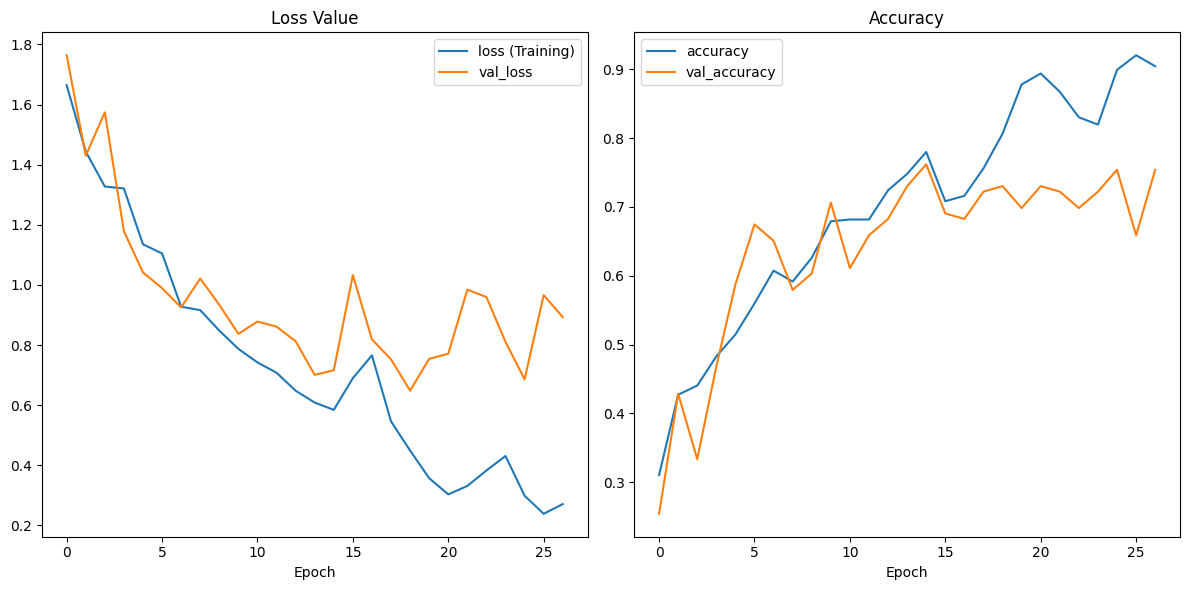

Test loss: 0.9124285578727722
Test accuracy: 0.7301587301587301
F1 Score: 0.740888815443535
Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.90      0.78        21
         1.0       0.78      0.64      0.70        39
         2.0       0.60      0.71      0.65        21
         3.0       0.85      1.00      0.92        11
         4.0       0.89      0.50      0.64        16
         5.0       0.74      0.78      0.76        18

    accuracy                           0.73       126
   macro avg       0.76      0.76      0.74       126
weighted avg       0.75      0.73      0.73       126



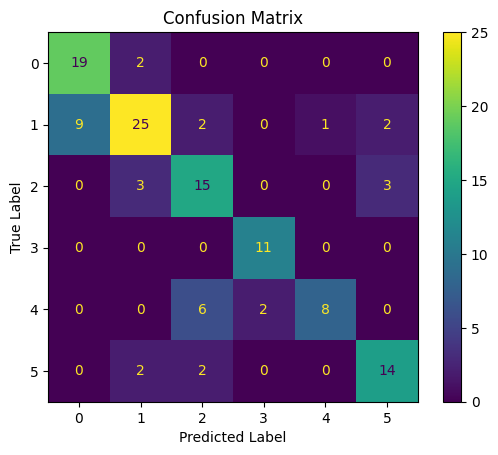

In [2]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=256, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        #x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(filters=512, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        #x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        # x = MaxPooling1D(pool_size=4)(x)
        x = Conv1D(filters=512, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3, input_shape4]
model = build_branched_model(input_shapes)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 1000, 256) │      5,376 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 1000, 256) │      2,816 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 1000, 256) │      2,816 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 1000, 256) │      5,376 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 997, 128)  │    131,200 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 997, 128)  │    131,200 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 997, 128)  │    131,200 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 997, 128)  │    131,200 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 997, 128)  │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 997, 128)  │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 997, 128)  │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 997, 128)  │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 996, 512)  │    131,584 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 996, 512)  │    131,584 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 996, 512)  │    131,584 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 996, 512)  │    131,584 │ dropout_4_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 512)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 1,338,438 (5.11 MB)

 Trainable params: 1,338,438 (5.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step - accuracy: 0.2488 - loss: 1.7269 - val_accuracy: 0.3651 - val_loss: 1.5455
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3791 - loss: 1.5161 - val_accuracy: 0.4206 - val_loss: 1.3670
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3989 - loss: 1.3258 - val_accuracy: 0.5317 - val_loss: 1.3267
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4930 - loss: 1.2949 - val_accuracy: 0.4286 - val_loss: 1.3298
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5185 - loss: 1.1963 - val_accuracy: 0.4603 - val_loss: 1.3088
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5443 - loss: 1.0876 - val_accuracy: 0.4286 - val_loss: 1.2767
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5373 - loss: 1.0738 - val_accuracy: 0.4841 - val_loss: 1.2488
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5219 - loss: 1.1808 - val_accuracy: 0.4921 - val_loss: 1

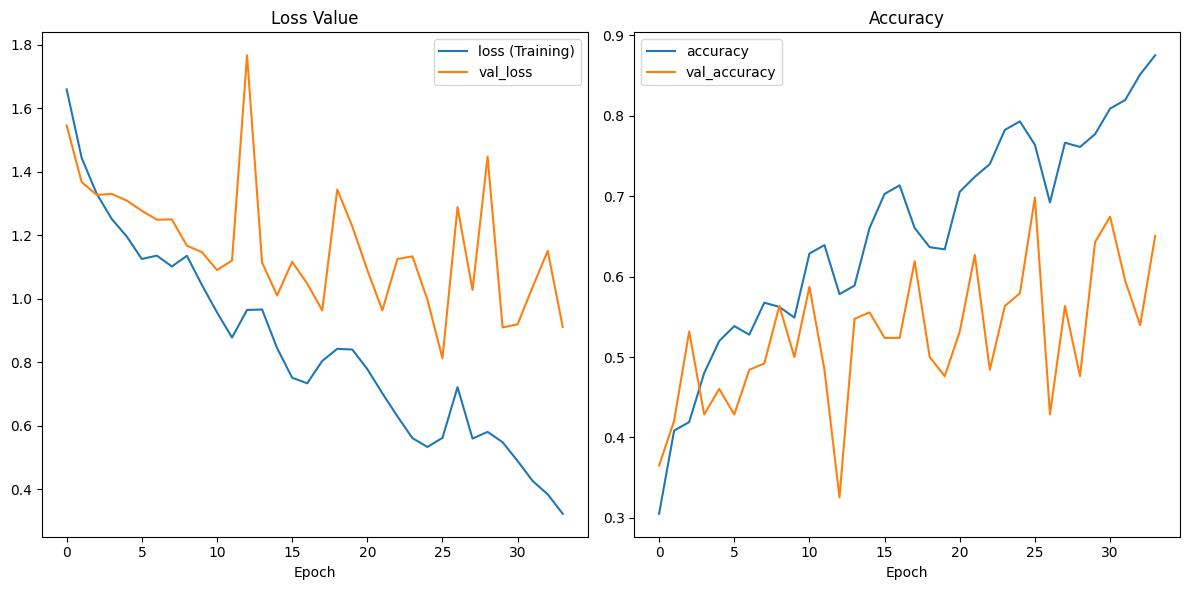

Test loss: 0.9194949269294739
Test accuracy: 0.6587301587301587
F1 Score: 0.666503426757577
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.90      0.83        21
         1.0       0.76      0.67      0.71        39
         2.0       0.43      0.62      0.51        21
         3.0       1.00      0.73      0.84        11
         4.0       1.00      0.44      0.61        16
         5.0       0.45      0.56      0.50        18

    accuracy                           0.66       126
   macro avg       0.74      0.65      0.67       126
weighted avg       0.71      0.66      0.67       126



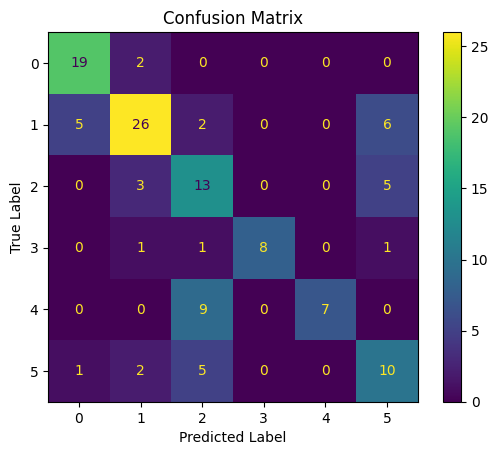

In [3]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=256, kernel_size=10, strides=2, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        #x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(filters=128, kernel_size=4, strides=1, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Conv1D(filters=512, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(128, activation='relu', name='dense_1')(merged)
    dense = Dense(64, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3, input_shape4]
model = build_branched_model(input_shapes)
model.summary()


X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=60, batch_size=32, patience=8, disp_labels=DISP_LABELS)

Epoch 1/80


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step - accuracy: 0.3121 - loss: 1.6873 - val_accuracy: 0.3968 - val_loss: 1.4403
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4055 - loss: 1.3808 - val_accuracy: 0.4365 - val_loss: 1.3703
Epoch 3/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5060 - loss: 1.2754 - val_accuracy: 0.4603 - val_loss: 1.2823
Epoch 4/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4651 - loss: 1.2332 - val_accuracy: 0.5159 - val_loss: 1.2324
Epoch 5/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5596 - loss: 1.1007 - val_accuracy: 0.5317 - val_loss: 1.1365
Epoch 6/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5376 - loss: 1.0453 - val_accuracy: 0.5317 - val_loss: 1.1025
Epoch 7/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5730 - loss: 1.0723 - val_accuracy: 0.5714 - val_loss: 1.0171
Epoch 8/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6512 - loss: 0.8569 - val_accuracy: 0.5873 - val_loss: 0.8894
E

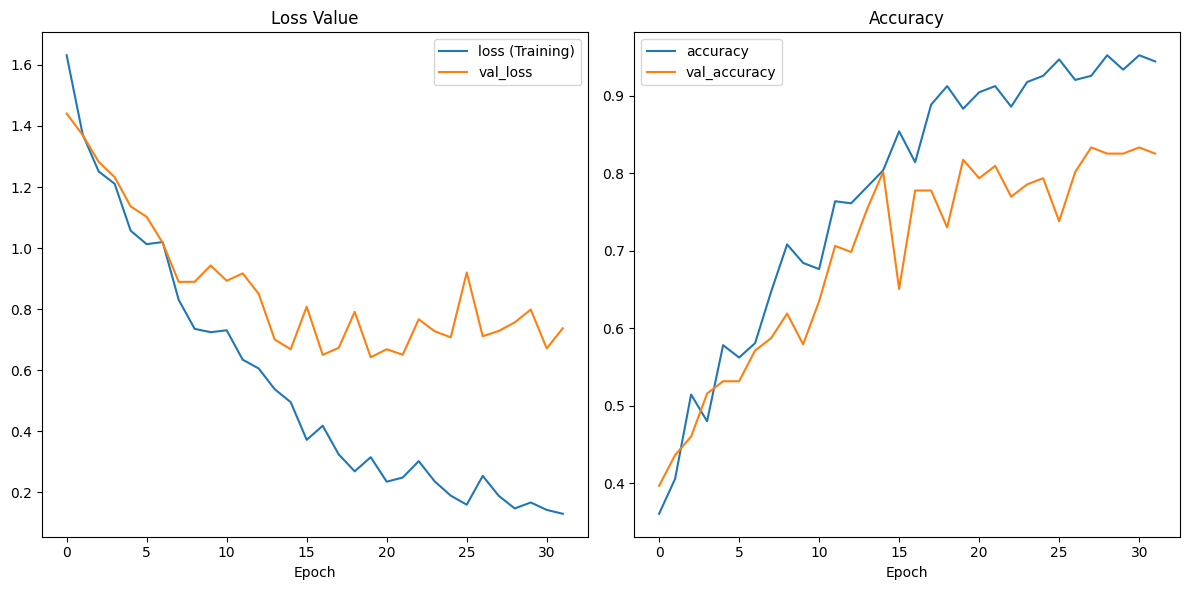

Test loss: 0.8370704054832458
Test accuracy: 0.7301587301587301
F1 Score: 0.7190888758604217
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.90      0.88        21
         1.0       0.91      0.77      0.83        39
         2.0       0.52      0.71      0.60        21
         3.0       0.71      0.91      0.80        11
         4.0       0.92      0.69      0.79        16
         5.0       0.44      0.39      0.41        18

    accuracy                           0.73       126
   macro avg       0.73      0.73      0.72       126
weighted avg       0.75      0.73      0.73       126



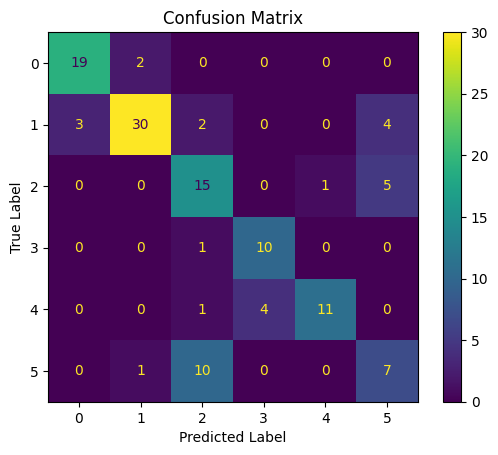

In [4]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64, kernel_size=100, strides=40, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        #x = MaxPooling1D(pool_size=2)(x)
        #x = Conv1D(filters=128, kernel_size=8, strides=4, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Conv1D(filters=128, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_4')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(32, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3, input_shape4]
model = build_branched_model(input_shapes)
#model.summary()


X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=80, batch_size=32, patience=12, disp_labels=DISP_LABELS)